In [1]:
import uncprop as up
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
from jax import config

from uncprop.core.inverse_problem import Posterior
from uncprop.core.surrogate import construct_design
from uncprop.utils.gpjax_models import construct_gp, train_gp_hyperpars
from uncprop.utils.plot import set_plot_theme
from uncprop.utils.grid import Grid
from uncprop.models.vsem.inverse_problem import VSEMPrior, VSEMLikelihood
from uncprop.models.vsem.surrogate import VSEMSurrogate

config.update("jax_enable_x64", True)
key = jr.key(53212)

colors = set_plot_theme()

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Construct VSEM Inverse Problem

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'unnormalized log posterior'}, xlabel='kext', ylabel='av'>)

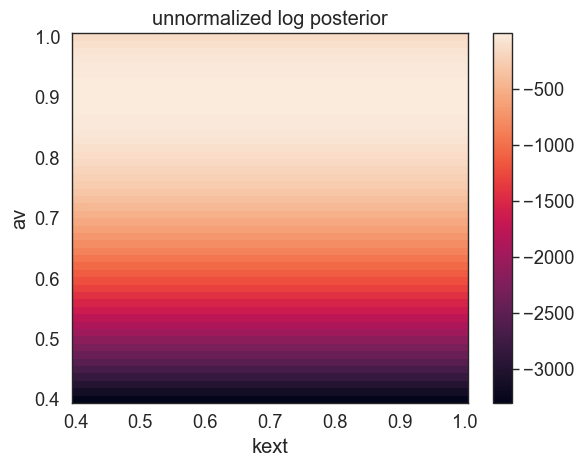

In [2]:
n_days = 365 * 2
par_names = ["kext", "av"]

key, key_prior, key_likelihood = jr.split(key, 3)

# exact posterior
prior = VSEMPrior(par_names)
true_param = prior.sample_all_vsem_params(key_prior)
likelihood = VSEMLikelihood(key=key_likelihood,
                            par_names=par_names,
                            n_days=n_days,
                            ground_truth=true_param)
posterior = Posterior(prior=prior, likelihood=likelihood)

# visualize posterior over grid
grid = Grid(low=prior.support[0],
            high=prior.support[1],
            n_points_per_dim=(50, 50),
            dim_names=prior.par_names)

grid.plot(f=lambda x: posterior.log_density(x),
          title='unnormalized log posterior')

### Fit Surrogate

In [3]:
key, key_design = jr.split(key, 2)

# sample design points
design = construct_design(key=key_design,
                          design_method='lhc', 
                          n_design=15, 
                          prior=prior,
                          f=lambda x: posterior.log_density(x))

# fit log-posterior surrogate
surrogate = VSEMSurrogate(design=design, exact_posterior=posterior)
surrogate.summarize_fit()

Initial loss 105.94096640418267
Final loss 89.35379297105527
gp scale: 1595.1361845729411
gp lengthscales: [0.55718015 0.35726202]
gp noise std dev: 1e-06
